# Quick Start

Here's a quick tutorial for those in a rush!

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import hemcee

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import numpy as np
import corner

First, specifiy the log probability (doesn't have to be normalized)
of your target distribution.
In this case, let's start with a simple Gaussian.

In [3]:
def log_prob(x):
    return - 0.5 * jnp.einsum('j,j->', x, x)

Now we can initalize the sampler. There are two types of samplers `hemcee.HamiltonianEnsembleSampeler` and `hemcee.EnsembleSampler`.
The `HamiltonianEnsembleSampler` implements the derivative-based algorithms detailed in [Y. Chen (2025)](https://arxiv.org/abs/2505.02987), and the `EnsembleSampler` implements the derivative-free algorithms detailed in [Goodman & Weare (2010)](https://msp.org/camcos/2010/5-1/camcos-v5-n1-p04-s.pdf) (for python implementation see [`emcee`](https://emcee.readthedocs.io/en/stable/))

Let's start with the novel part of this package...

## `HamiltonianEnsembleSampler`
In Chen's paper, he details a couple of affine invariant sampling scheme. He comes to the conclusion that the walk move (Algorithm 3 in [Y. Chen (2025)](https://arxiv.org/abs/2505.02987)) performs the best overall, so our package defaults to that.

In [4]:
dim = 3
total_chains = 20

# Hamiltonian Monte Carlo hyperparameters
step_size: float = 0.1 # Step size of leapfrog integrator
L: int = 10            # Number of leapfrog steps

# Inintalize the sampler
sampler = hemcee.HamiltonianEnsembleSampler(
    total_chains=total_chains,
    dim=dim, # <- dimension of the probability distribution
    log_prob=log_prob, # <- log probability goes here!
    step_size=step_size,
    L=L,
)

Now, we can run the sampler!

In [ ]:
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 2)

inital_states = jax.random.normal(keys[0], shape=(total_chains, dim))

samples = sampler.run_mcmc(
    key=keys[1], # <- JAX is used under the hood, so we need to pass in a `key`
    initial_state=inital_states,
    num_samples=10**5,
    warmup=10**5,
)
print('Diagnostics:')
print(sampler.diagnostics_main)

tau = hemcee.autocorr.integrated_time(samples)
print('Integrated autocorrelation time:')
print(tau)

Using 42 total chains: Group 1 (21), Group 2 (21)
Diagnostics:
{'accepts': Array([79879., 80085., 80088., 80028., 79942., 80098., 80066., 80006.,
       79693., 80066., 80072., 79954., 79663., 80096., 79885., 80109.,
       79965., 79978., 79795., 79839., 79637., 79966., 80000., 79971.,
       79882., 79734., 79829., 80168., 80053., 79843., 80070., 79760.,
       79914., 79866., 79723., 80219., 79972., 80009., 80104., 80186.,
       80194., 79936.], dtype=float64), 'acceptance_rate': Array([0.79879, 0.80085, 0.80088, 0.80028, 0.79942, 0.80098, 0.80066,
       0.80006, 0.79693, 0.80066, 0.80072, 0.79954, 0.79663, 0.80096,
       0.79885, 0.80109, 0.79965, 0.79978, 0.79795, 0.79839, 0.79637,
       0.79966, 0.8    , 0.79971, 0.79882, 0.79734, 0.79829, 0.80168,
       0.80053, 0.79843, 0.8007 , 0.7976 , 0.79914, 0.79866, 0.79723,
       0.80219, 0.79972, 0.80009, 0.80104, 0.80186, 0.80194, 0.79936],      dtype=float64)}
Autocorrelation time:
[1.59190163 1.59153505 1.59052112 1.59148422 1.

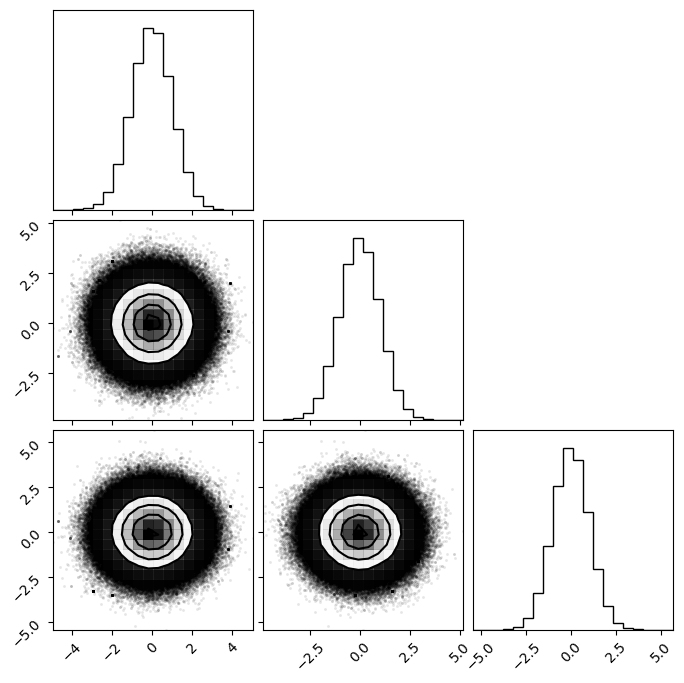

In [6]:
# Visualize results using `corner`
_ = corner.corner(np.array(samples.reshape(-1, dim)))

But this is way too easy, let's try to sample a highly skewed distribution! Due to our procedures being affine-invariant, your sampler won't fail in such regimes.

In [16]:
# Settings
dim = 7
total_chains = dim * 6
cond_number = 1000 # Condition number of covariance matrix

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 4)


# Distribution
eigenvals = 0.1 * jnp.linspace(1, cond_number, dim)
H = jax.random.normal(keys[0], shape=(dim, dim))
Q, _ = np.linalg.qr(H)
precision = Q @ np.diag(eigenvals) @ Q.T
precision = 0.5 * (precision + precision.T)

true_mean = jax.random.normal(keys[1], shape=(dim,))
precision_matrix = jnp.array(precision)

def log_prob(x):
    """Vectorized log density (potential energy)"""        
    # Vectorized operation for all samples
    centered = x - true_mean
    result = - 0.5 * jnp.einsum('j,jk,k->', centered, precision_matrix, centered)
        
    return result

# Sampler
sampler = hemcee.HamiltonianEnsembleSampler(
    total_chains=total_chains,
    dim=dim,
    log_prob=log_prob,
    step_size=0.1,
    L=10,
)

inital_states = jax.random.normal(keys[2], shape=(total_chains, dim))

samples = sampler.run_mcmc(
    key=keys[3],
    initial_state=inital_states,
    num_samples=10**5,
    warmup=10**5,
)

tau = hemcee.autocorr.integrated_time(samples)
print('Integrated autocorrelation time:')
print(tau)


Using 42 total chains: Group 1 (21), Group 2 (21)
Integrated autocorrelation time:
[1.60452262 1.6033496  1.60195625 1.60382418 1.6052014  1.60246373
 1.60297288]


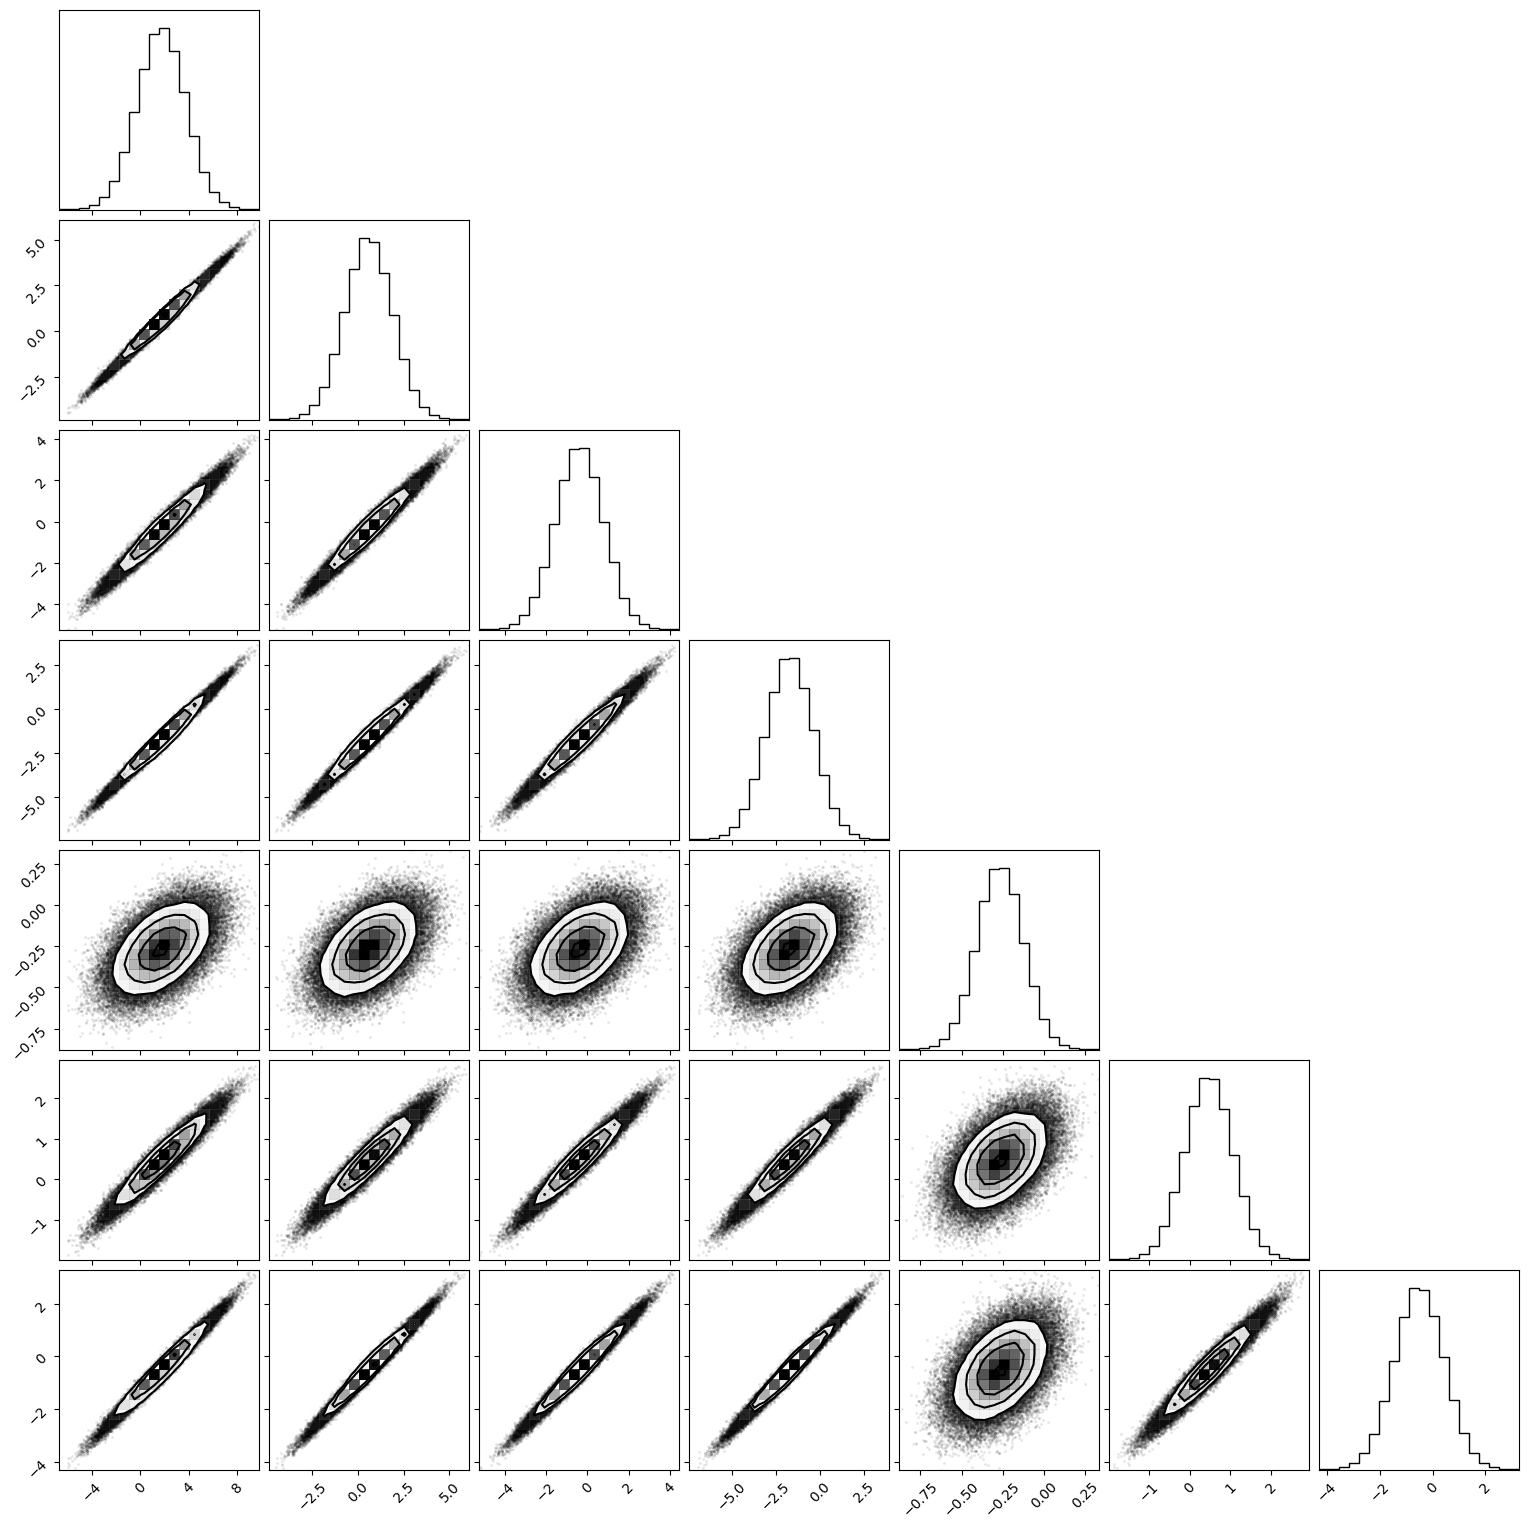

In [17]:
n_show = 100000 # Makes plotting faster
_ = corner.corner(np.array(samples.reshape(-1, dim))[:n_show])

### Rosenbrock

In [19]:
from hemcee.tests.distribution import make_rosenbrock
from hemcee.moves.hamiltonian.hmc_side import hmc_side_move

keys = jax.random.split(jax.random.PRNGKey(0), 4)
total_chains = 26
dim = 5 

log_prob  = make_rosenbrock(jax.random.PRNGKey(0))

sampler = hemcee.HamiltonianEnsembleSampler(
    total_chains=total_chains,
    dim=dim,
    log_prob=log_prob,
    step_size=0.01,
    L=15,
)

inital_states = jax.random.normal(keys[2], shape=(total_chains, dim))

samples = sampler.run_mcmc(
    key=keys[3],
    initial_state=inital_states,
    num_samples=10**5,
    warmup=10**5,
    adapt_step_size=True, # This is a difficult problem, so let's adapt the step size!
    # adapt_integration_time=True, # and the integration time!
)

tau = hemcee.autocorr.integrated_time(samples)
print('Integrated autocorrelation time:')
print(tau)

Using 26 total chains: Group 1 (13), Group 2 (13)
Integrated autocorrelation time:
[555.48588084 123.10811925 108.96434546 123.59531505 197.11801189]


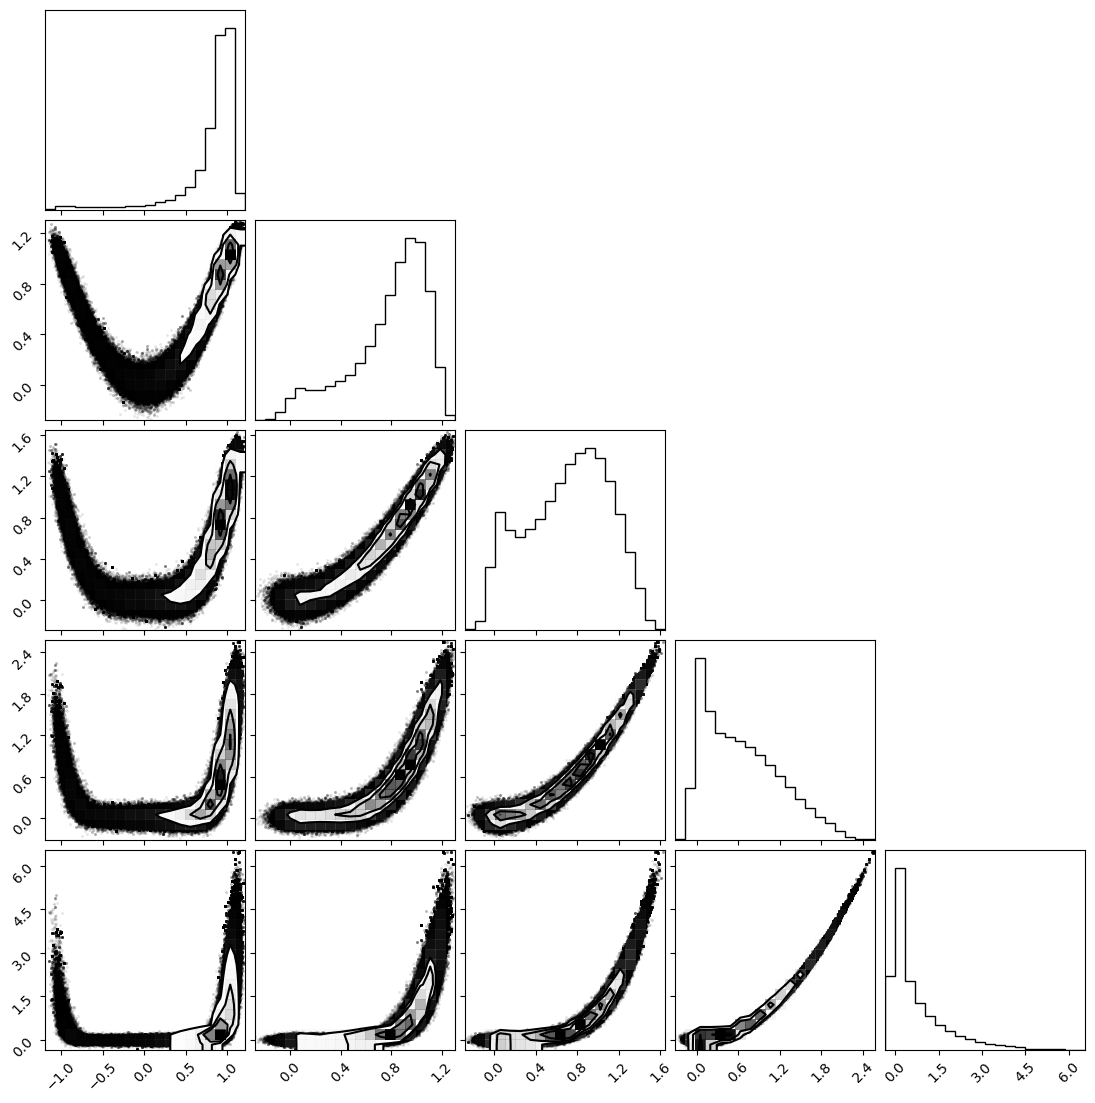

In [20]:
_ = corner.corner(np.array(samples.reshape(-1, dim)))

In [22]:
from hemcee.moves.vanilla.stretch import stretch_move

sampler = hemcee.EnsembleSampler(
    total_chains=total_chains,
    dim=dim,
    log_prob=log_prob,
    move=stretch_move,
)

samples = sampler.run_mcmc(
    key=jax.random.PRNGKey(0),
    initial_state=inital_states,
    num_samples=10**5,
    warmup=10**5,
)

tau = hemcee.autocorr.integrated_time(samples)
print('Integrated autocorrelation time:')
print(tau)


Using 26 total chains: Group 1 (13), Group 2 (13)


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [2204.84700975 1334.65707175 1411.8339193  1535.66839678 1635.69041151]

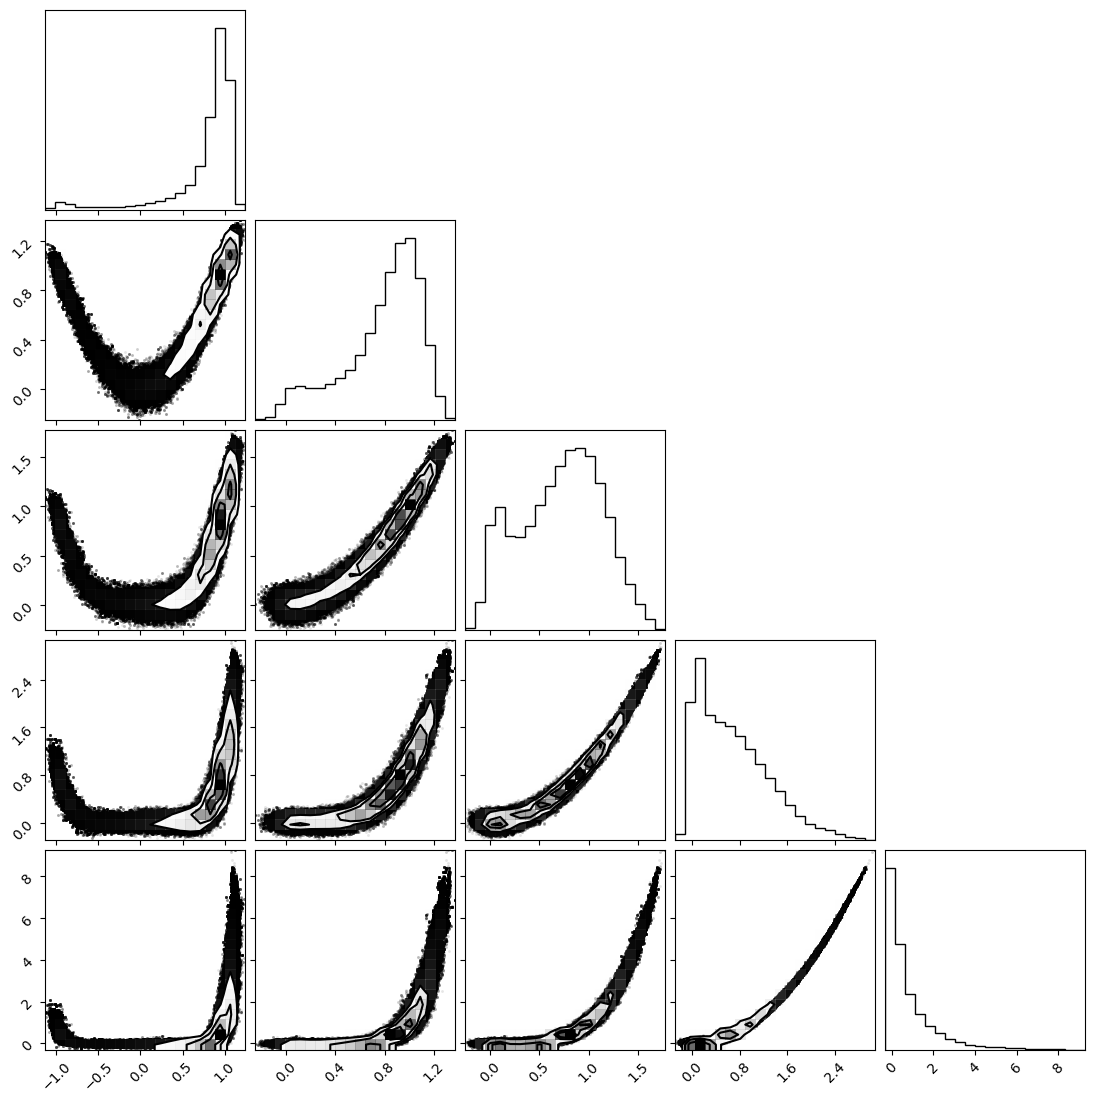

In [23]:
_ = corner.corner(np.array(samples.reshape(-1, dim)))